In [21]:
import kmeans, library
from matplotlib import pyplot
import time
import numpy

In [126]:
t0 = time.time()
pickle_dir = 'C:\\Users\\Colin\\Documents\\SCHOOL_STUFF\\EWU\\W21\\CSCD_530\\Project\\Code\\data_after_removing_words'

t = time.time()
num_docs = 160
vocab, docs = library.load_project(pickle_dir, num_docs, random_files=True)
print(f"loaded {num_docs:,} docs {time.time()-t:.2f}")

t = time.time()
sub_corpus_freqs = kmeans.sub_corpus_frequencies(docs)
print(f"recalc frequencies {time.time()-t:.2f}")  

loaded 160 docs 4.18
recalc frequencies 0.04


# Elbow Method + Silhoette Method

In [97]:
def get_WCSSE(cluster_results):
    wsse = 0
    for i in range(len(cluster_results.clusters)):
        for doc in cluster_results.clusters[i]:
            wsse += kmeans.item_distance_dot_product(doc, cluster_results.centroids[i])**2
    return wsse

def get_silhouette(cluster_results):
    # Using equations from
    # https://en.wikipedia.org/wiki/Silhouette_%28clustering%29
    silhouettes = []
    for i in range(len(cluster_results.clusters)):
        cluster = cluster_results.clusters[i]
        if len(cluster) == 1:
            silhouettes.append(0)
        else:
            for j in range(len(cluster)):
                docj = cluster[j]
                docj_separation = []
                docj_cohesion = []
                for k in range(len(cluster_results.clusters)):
                    # Loop clusters for each document to get separation
                    if k != i: # Do not want distance to docj's assigned cluster centroid
                        docj_separation.append(kmeans.item_distance_dot_product(docj, cluster_results.centroids[k]))
                for k in range(j+1, len(cluster)):
                    # Add up distances between all pairs of docs in cluster to get cohesion
                    dock = cluster[k]
                    docj_cohesion.append(kmeans.item_distance_dot_product(docj,dock))
                docj_cohesion = (1/(len(cluster)-1))*sum(docj_cohesion)
                docj_separation = min(docj_separation)/len(cluster)
                silhouettes.append((docj_separation-docj_cohesion)/max(docj_cohesion,docj_separation))
    return numpy.average(silhouettes)

'''
def cluster_metrics(cluster_results):
    # Calculates Within Cluster Sum of Square Error (WSSE) to use for Elbow Method and Silhouette value
    # Silhouette source:
    # https://en.wikipedia.org/wiki/Silhouette_%28clustering%29
    # TODO: Update distance metric to be 1/(dot product)
    silhouettes = []
    wsse = 0
    for i in range(len(cluster_results.clusters)):
        # Loop clusters
        cluster_size = len(cluster_results.clusters[i])
        if cluster_size == 1:
            silhouettes.append(0)
        else:
            for j in range(len(cluster_results.clusters[i])):
                # Loop documents in cluster    
                docj = cluster_results.clusters[i][j]
                wsse += kmeans.item_distance_dot_product(docj, cluster_results.centroids[i])**2
                docj_separation = []
                docj_cohesion = []
                for k in range(len(cluster_results.clusters)):
                    # Loop clusters for each document to get min separation
                    docj_separation.append(kmeans.item_distance_dot_product(docj, cluster_results.centroids[k]))
                # For each pair of documents in the cluster
                for k in range(j+1, len(cluster_results.clusters[i])):
                    # Loop through remaining documents in cluster
                    dock = cluster_results.clusters[i][k]
                    docj_cohesion.append(kmeans.item_distance_dot_product(docj,dock))
                docj_cohesion = (1/(cluster_size-1))*sum(docj_cohesion)
                docj_separation.remove(min(docj_separation))
                docj_separation = min(docj_separation)/cluster_size
                silhouettes.append((docj_separation-docj_cohesion)/max(docj_cohesion,docj_separation))
    return wsse, mean(silhouettes)
'''

'\ndef cluster_metrics(cluster_results):\n    # Calculates Within Cluster Sum of Square Error (WSSE) to use for Elbow Method and Silhouette value\n    # Silhouette source:\n    # https://en.wikipedia.org/wiki/Silhouette_%28clustering%29\n    # TODO: Update distance metric to be 1/(dot product)\n    silhouettes = []\n    wsse = 0\n    for i in range(len(cluster_results.clusters)):\n        # Loop clusters\n        cluster_size = len(cluster_results.clusters[i])\n        if cluster_size == 1:\n            silhouettes.append(0)\n        else:\n            for j in range(len(cluster_results.clusters[i])):\n                # Loop documents in cluster    \n                docj = cluster_results.clusters[i][j]\n                wsse += kmeans.item_distance_dot_product(docj, cluster_results.centroids[i])**2\n                docj_separation = []\n                docj_cohesion = []\n                for k in range(len(cluster_results.clusters)):\n                    # Loop clusters for each docume

In [98]:
def optimal_k_WCSS(K, WCSS,threshold):
    for i in range(1,len(WCSS)):
        if WCSS[i-1]-WCSS[i] < threshold:
            return K[i-1]
    return len(WCSS)

def optimal_k_silhouette(K,silhouettes):
    max_idx = 0
    for i in range(1,len(silhouettes)):
        if silhouettes[max_idx] < silhouettes[i]:
            max_idx = i
    return K[max_idx]

In [127]:
up_to_avg_docs_per_cluster = 4
#kmax = int(num_docs/up_to_avg_docs_per_cluster)
kmax = 10
K = []
WCSS = []
silhouettes = []

for k in range(2,kmax):
    K.append(k)
    results = kmeans.find_clusters(docs, k);
    #wsse, silhouette = cluster_metrics(results)
    t = time.time()
    WCSS.append(get_WCSSE(results))
    print(f"WCSSE {time.time()-t:.2f}")

    t = time.time()
    silhouettes.append(get_silhouette(results))

# Calculate optimal k - still working on this
scaled_WCSS = [x/WCSS[0] for x in WCSS]
optimal_k_from_WCSS = optimal_k_WCSS(K,scaled_WCSS,0.05)
optimal_k_from_silhouettes = optimal_k_silhouette(K,silhouettes)

iteration 1 (0.03s) [93, 67] skipped 0
centroid length: 189 (0.03s)
centroid length: 248 (0.03s)
iteration 2 (0.02s) [86, 74] skipped 0
centroid length: 207 (0.02s)
centroid length: 235 (0.02s)
iteration 3 (0.02s) [86, 74] skipped 0
WCSSE 0.01
iteration 1 (0.04s) [86, 61, 13] skipped 0
centroid length: 204 (0.02s)
centroid length: 275 (0.02s)
centroid length: 365 (0.00s)
iteration 2 (0.03s) [71, 51, 38] skipped 0
centroid length: 237 (0.02s)
centroid length: 340 (0.01s)
centroid length: 245 (0.01s)
iteration 3 (0.03s) [69, 52, 39] skipped 0
centroid length: 246 (0.02s)
centroid length: 339 (0.01s)
centroid length: 239 (0.01s)
iteration 4 (0.03s) [69, 52, 39] skipped 0
WCSSE 0.01
iteration 1 (0.06s) [66, 25, 54, 15] skipped 0
centroid length: 265 (0.02s)
centroid length: 285 (0.01s)
centroid length: 293 (0.01s)
centroid length: 366 (0.00s)
iteration 2 (0.04s) [60, 27, 54, 19] skipped 0
centroid length: 280 (0.02s)
centroid length: 290 (0.01s)
centroid length: 293 (0.01s)
centroid length

In [100]:
pyplot.rcParams["figure.figsize"] = (20,4)

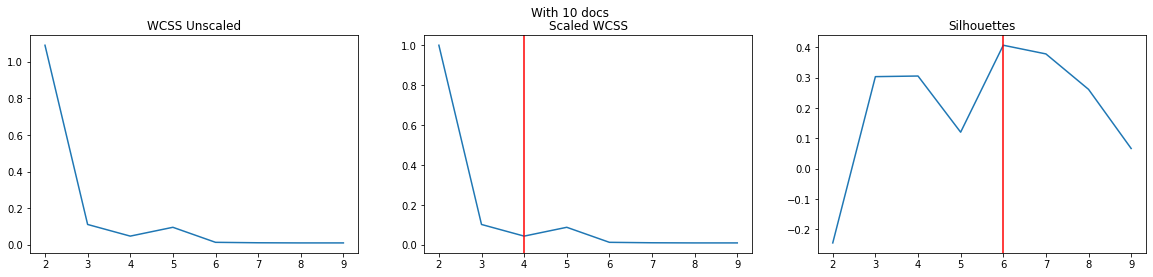

In [101]:
figure, axis = pyplot.subplots(1,3)
figure.suptitle(f'With {num_docs} docs')

axis[0].plot(K, WCSS);
axis[0].set_title('WCSS Unscaled');

axis[1].plot(K, scaled_WCSS);
axis[1].axvline(x=optimal_k_from_WCSS, color='r');
axis[1].set_title('Scaled WCSS');

axis[2].plot(K, silhouettes);
axis[2].axvline(x=optimal_k_from_silhouettes, color='r');
axis[2].set_title('Silhouettes');

pyplot.show();

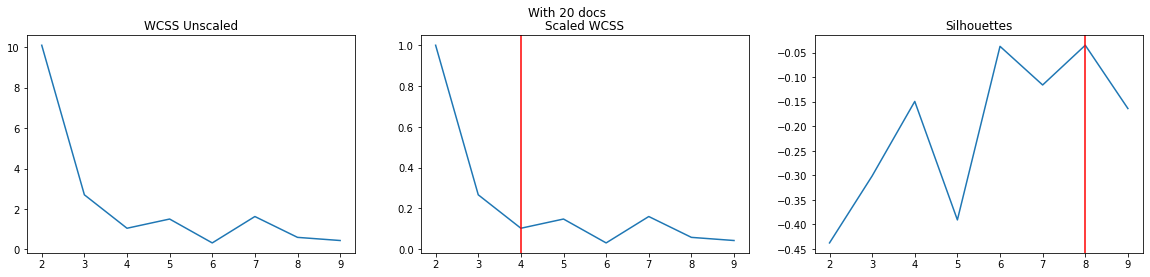

In [110]:
figure, axis = pyplot.subplots(1,3)
figure.suptitle(f'With {num_docs} docs')

axis[0].plot(K, WCSS);
axis[0].set_title('WCSS Unscaled');

axis[1].plot(K, scaled_WCSS);
axis[1].axvline(x=optimal_k_from_WCSS, color='r');
axis[1].set_title('Scaled WCSS');

axis[2].plot(K, silhouettes);
axis[2].axvline(x=optimal_k_from_silhouettes, color='r');
axis[2].set_title('Silhouettes');

pyplot.show();

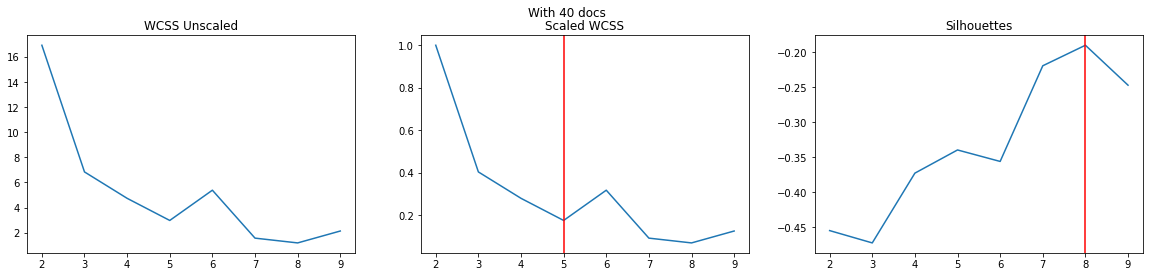

In [113]:
figure, axis = pyplot.subplots(1,3)
figure.suptitle(f'With {num_docs} docs')

axis[0].plot(K, WCSS);
axis[0].set_title('WCSS Unscaled');

axis[1].plot(K, scaled_WCSS);
axis[1].axvline(x=optimal_k_from_WCSS, color='r');
axis[1].set_title('Scaled WCSS');

axis[2].plot(K, silhouettes);
axis[2].axvline(x=optimal_k_from_silhouettes, color='r');
axis[2].set_title('Silhouettes');

pyplot.show();

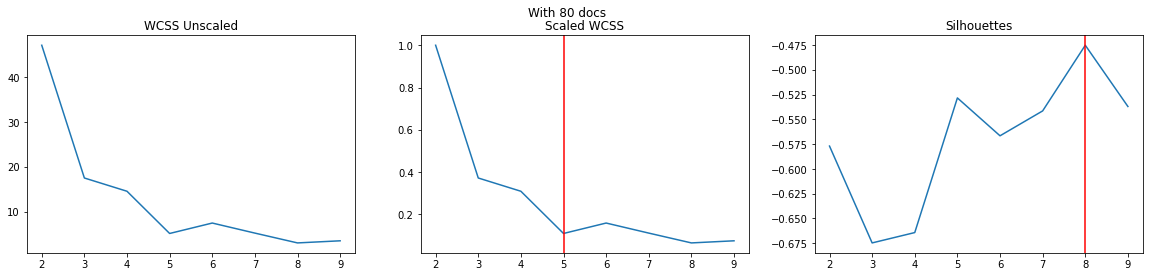

In [117]:
figure, axis = pyplot.subplots(1,3)
figure.suptitle(f'With {num_docs} docs')

axis[0].plot(K, WCSS);
axis[0].set_title('WCSS Unscaled');

axis[1].plot(K, scaled_WCSS);
axis[1].axvline(x=optimal_k_from_WCSS, color='r');
axis[1].set_title('Scaled WCSS');

axis[2].plot(K, silhouettes);
axis[2].axvline(x=optimal_k_from_silhouettes, color='r');
axis[2].set_title('Silhouettes');

pyplot.show();

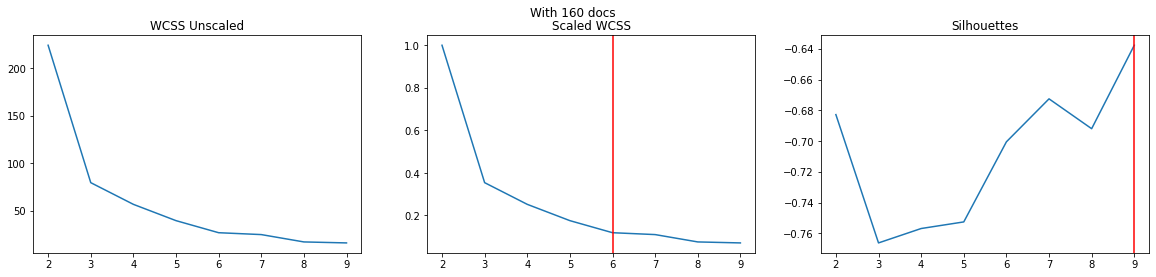

In [128]:
figure, axis = pyplot.subplots(1,3)
figure.suptitle(f'With {num_docs} docs')

axis[0].plot(K, WCSS);
axis[0].set_title('WCSS Unscaled');

axis[1].plot(K, scaled_WCSS);
axis[1].axvline(x=optimal_k_from_WCSS, color='r');
axis[1].set_title('Scaled WCSS');

axis[2].plot(K, silhouettes);
axis[2].axvline(x=optimal_k_from_silhouettes, color='r');
axis[2].set_title('Silhouettes');

pyplot.show();

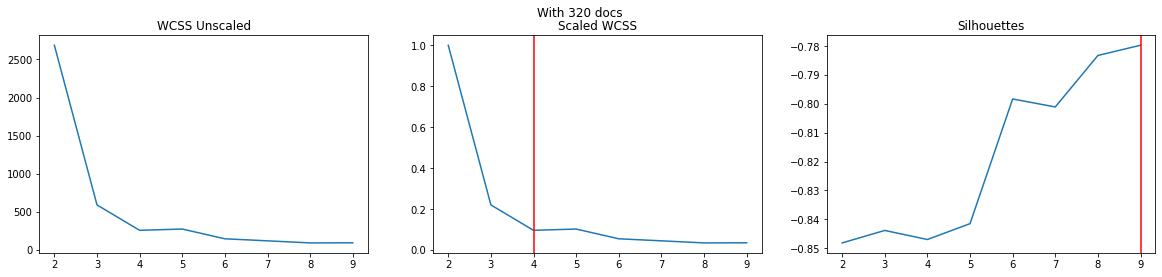

In [125]:
figure, axis = pyplot.subplots(1,3)
figure.suptitle(f'With {num_docs} docs')

axis[0].plot(K, WCSS);
axis[0].set_title('WCSS Unscaled');

axis[1].plot(K, scaled_WCSS);
axis[1].axvline(x=optimal_k_from_WCSS, color='r');
axis[1].set_title('Scaled WCSS');

axis[2].plot(K, silhouettes);
axis[2].axvline(x=optimal_k_from_silhouettes, color='r');
axis[2].set_title('Silhouettes');

pyplot.show();